In [41]:
import numpy
from matplotlib import pyplot as plt
import cv2
import pytesseract
import os
from imutils.object_detection import non_max_suppression
%matplotlib inline

os.chdir("/Users/krishanusaha/Desktop/T&S/OCR/")
pytesseract.pytesseract.tesseract_cmd=r'/opt/homebrew/bin/tesseract'

In [42]:
min_confidence = 0.5

def decode_predictions(scores, geometry):   
    (num_rows, num_cols) = scores.shape[2:4]
    rects, confidences = [], []
    for y in range(0, num_rows):
        scores_data = scores[0, 0, y]
        x_data0, x_data1 = geometry[0, 0, y], geometry[0, 1, y]
        x_data2, x_data3 = geometry[0, 2, y], geometry[0, 3, y]
        angles_data = geometry[0, 4, y]
        for x in range(0, num_cols):
            if scores_data[x] < min_confidence: continue 
            (offset_x, offset_y) = (x * 4.0, y * 4.0) 
            angle = angles_data[x]
            cos, sin = np.cos(angle), np.sin(angle) 
            h, w = x_data0[x] + x_data2[x], x_data1[x] + x_data3[x] 
            end_x = int(offset_x + (cos * x_data1[x]) + \
                    (sin * x_data2[x]))
            end_y = int(offset_y - (sin * x_data1[x]) + \
                    (cos * x_data2[x]))
            start_x, start_y = int(end_x - w), int(end_y - h) 
            rects.append((start_x, start_y, end_x, end_y))
            confidences.append(scores_data[x]) 
    return (rects, confidences)

In [43]:
im = 'Sample KTPs/1622826876_ktp-weldi-watermark.jpg'
image = cv2.imread(im)
orig = image.copy()
(orig_height, orig_width) = image.shape[:2]
width = height = 32*10
(w, h) = (width, height)
r_width, r_height = orig_width / float(w), orig_height / float(h)
image = cv2.resize(image, (w, h))
(h, w) = image.shape[:2]

In [44]:
layer_names = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
net = cv2.dnn.readNet('EAST-Detector-for-text-detection-using-OpenCV/frozen_east_text_detection.pb')

In [45]:
b, g, r = np.mean(image[...,0]), np.mean(image[...,1]), np.mean(image[...,2])
blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (b, g, r), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layer_names)

In [46]:
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [47]:
padding = 0.001 #0.01 #0.5
results = []
# loop over the bounding boxes
for (start_x, start_y, end_x, end_y) in boxes:
    start_x, start_y = int(start_x*r_width), int(start_y*r_height)
    end_x, end_y =  int(end_x*r_width), int(end_y*r_height)
    d_x, d_y = int((end_x - start_x) * padding), \
               int((end_y - start_y) * padding)
    start_x, start_y = max(0, start_x - d_x*2), \
                       max(0, start_y - d_y*2)
    end_x, end_y = min(orig_width, end_x + (d_x * 2)), \
                   min(orig_height, end_y + (d_y * 2))
    roi = orig[start_y:end_y, start_x:end_x]
    # config = ("-l eng --oem 1 --psm 11")
    config = ("-l ind --oem 1 --psm 11")
    text = pytesseract.image_to_string(roi, config=config)
    results.append(((start_x, start_y, end_x, end_y), text))
    results = sorted(results, key=lambda r:r[0][1])

In [48]:
output = orig.copy()
for ((start_x, start_y, end_x, end_y), text) in results:
    # strip out non-ASCII text so we can draw the text on the image 
    text = "".join([c if ord(c) < 128 else "" for c \
            in text]).strip()
    cv2.rectangle(output, (start_x, start_y), (end_x, end_y), \
                          (0, 255, 0), 2)
    cv2.putText(output, text, (start_x, start_y-20), \
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 3)    

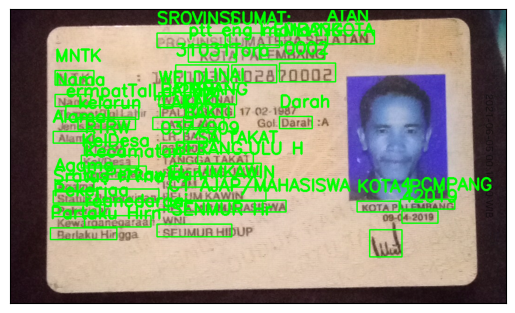

In [49]:
plt.imshow(output, 'gray')
plt.xticks([]),plt.yticks([])
plt.show()

In [50]:
results

[((679, 45, 779, 74), 'ATAN\n'),
 ((314, 51, 460, 82), 'SROVINSI\n'),
 ((470, 51, 576, 82), 'SUMAT:\n'),
 ((533, 76, 673, 107), 'I EMBANG\n'),
 ((381, 76, 484, 113), 'ptt eng maha\n\nKOTA\n'),
 ((576, 115, 696, 155), "'»0002\n"),
 ((474, 119, 570, 157), 'Tora\n'),
 ((354, 119, 467, 158), '31031,\n'),
 ((96, 131, 179, 162), 'MNTK\n'),
 ((414, 172, 484, 204), 'LINAI\n'),
 ((318, 178, 401, 208), 'WELDI\n'),
 ((96, 182, 172, 208), 'Nama\n'),
 ((381, 202, 480, 231), 'MBANG\n'),
 ((321, 204, 401, 231), 'PALEN\n'),
 ((119, 206, 275, 235), 'ermpatTalLat\n\nna\n'),
 ((576, 229, 646, 255), 'Darah\n'),
 ((371, 229, 457, 257), 'LAKI\n'),
 ((145, 231, 268, 257), 'kelarun\n'),
 ((305, 231, 391, 257), '"LAKI\n'),
 ((371, 253, 450, 282), 'BAKTI\n'),
 ((92, 261, 179, 286), 'Alamal\n'),
 ((159, 284, 242, 310), 'RTRW\n'),
 ((321, 286, 414, 310), '037/009\n'),
 ((401, 306, 520, 331), 'SA TAKAT\n'),
 ((152, 312, 275, 339), 'KelDesa\n'),
 ((351, 329, 537, 357), 'BERANG.ULU H\n'),
 ((159, 335, 291, 363), 'Ke